In [2]:
# -*- coding: utf-8 -*-
import sys
import os
from datetime import datetime

import yaml

import numpy as np

from skimage.transform import resize
from skimage.measure import compare_mse as mse
from skimage.measure import compare_ssim as ssim

import matplotlib.pyplot as plt

In [1]:
from dip_utils.inpainting_utils import optimize
from dip_utils.inpainting_utils import var_to_np, np_to_var

import dip
import torchmath as tm
import image_utility as iu

## Cost Function

The cost function minimise the following equation:

$$
\underset{\theta}{\arg\min}\,(1+\alpha)\left(\|\mathbf{P}_\Omega\mathbf{\Psi}f_\theta(\vec{z})-\vec{b}\|^2_2+\alpha\|\mathbf{P}_\Omega^C\mathbf{\Psi}f_\theta(\vec{z})-\vec{c}\|^2_2\right)
$$

In [3]:
def costfunction():
    """NN Cost function: to minimise."""
    global net
    global net_input

    global P_omg_var
    global b_var

    global alpha
    global P_cmp_var
    global c_var

    return dip.costfunction(net, net_input, P_omg_var,
                            b_var, alpha, P_cmp_var, c_var)


Configuration and loading of dataset

In [20]:
datafolder = '../datasets/'
dataset = 'OASIS'
fformat = '.png'
shape = (256, 256)
tshape = (1, *shape) # torch shape
num_iter = 1000
alpha = 0.01
srate = 0.03
# size of signal
n = np.prod(shape)

In [5]:
print('load training dataset...', end='', flush=True)
training = iu.load_images(f'{datafolder}/{dataset}-training',
                          fformat=fformat)
training = [resize(x, shape, mode='reflect') for x in training]
print(' [done]')

load training dataset... [done]


In [6]:
""" Load testing set."""
print('load testing dataset...', end='', flush=True)
testing = iu.load_images(f'{datafolder}/{dataset}-testing',
                          fformat=fformat)
testing = [resize(x, shape, mode='reflect') for x in testing]
idx_s = np.random.choice(len(testing))

print(' [done]')

print testing dataset... [done]


Compute support set $\Omega$ from training dataset as for $f_{avg}$ and prior $\vec{c}$ as average of the training dataset.

In [7]:
""" Find sampling pattern."""
print('extracting information...')
Training = [tm.dct2(x).reshape(-1) for x in training]
Omega = np.var(Training, 0).argsort()[::-1]
prior = np.mean(Training, 0).reshape(tshape)
Prior = tm.dct3(prior)
print(' [done]')


extracting information...
 [done]


In [21]:
m = int(round(srate*n))
P_omega = np.zeros(n)
P_omega[Omega[:m]] = 1
P_omega = (P_omega.reshape(tshape))
P_omg_var = np_to_var(P_omega).type(dip.dtype)
P_compl = 1 - P_omega
P_cmp_var = np_to_var(P_compl).type(dip.dtype)

Computing both $k$-best, $f_{avg}$ and DIP reconstruction and shows results.

In [22]:
img_np = testing[idx_s].reshape(tshape)

# Observed Signal
b = tm.dct3(img_np) * P_omega
# Torch variable
b_var = np_to_var(b).type(dip.dtype)

# Prior Signal
c = Prior * P_compl
# torch variable
c_var = np_to_var(c).type(dip.dtype)

""" Compute $k$-best and $f_{avg}$."""
X = tm.dct3(img_np).reshape(-1)
O = np.abs(X).argsort()[::-1][m:]
X[O] = 0
x = iu.norm(tm.idct2(X.reshape(shape)))

fa =  iu.norm(tm.idct3(b).reshape(shape))


In [23]:
""" Init net """
net, net_input, params, OPTIMIZER, LR = dip.init_net(tshape)
""" Optimize net """
optimize(OPTIMIZER, params, costfunction, LR=LR, num_iter=num_iter)


Starting optimization with ADAM


In [24]:
out = net(net_input)
out_np = iu.norm(var_to_np(out).reshape(shape))
pout = iu.norm(tm.idct2(tm.dct2(out_np)*P_compl.reshape(shape)+
                            b.reshape(shape)))

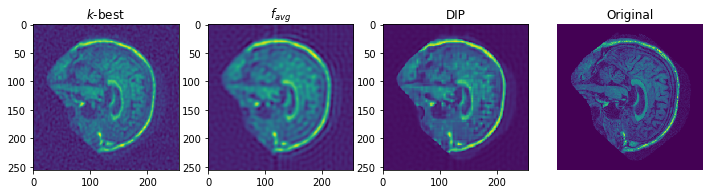

In [25]:
plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.imshow(x.reshape(shape))
plt.title('$k$-best')
plt.subplot(1,4,2)
plt.imshow(fa.reshape(shape))
plt.title('$f_{avg}$')
plt.subplot(1,4,3)
plt.imshow(pout.reshape(shape))
plt.title('DIP')
plt.subplot(1,4,4)
plt.imshow(img_np.reshape(shape))
plt.title('Original')
plt.axis('off')

plt.show()